# Analyse sémantique avec [BERTopic](https://maartengr.github.io/BERTopic/index.html)

BERTopic est un package python qui facilite la détection de sujets/thématiques dans des corpus par clustering d'embeddings.
Il permet d'imbriquer facilement des modèles et techniques existants (qu'il s'agisse de calcul d'embeddings, de réduction de dimensionalité, clustering, etc.).

Il offre une certaine flexibilité puisque l'utilisateur a la possibilité de choisir chaque brique du processus.

![](output/bert.svg "")

## Embeddings

- BERT: "*contextualized embeddings*" dérivés à travers un méchanisms d'attention, tirant partie des interactions entre plusieurs *tokens* dans une séquence (e.g. une phrase). Tâche d'entrainement: prédiction d'un mot masqué dans une séquence, à partir du contexte.
- SBERT: dérivation d'embeddings au niveau des phrases elle-même. Tâche d'entraînement: prédiction de similarité entre des paires de phrases.

De nombreux modèles pré-entraînés sur de très larges corpus sont disponibles. Ces grands corpus d'entraînement leur permettent de mieux appréhender la structure des langues couvertes. Si nécessaire, les modèles peut-être adaptés (fine-tuned) à un corpus particulier ou pour une tâche particulière.

### Limitations

 - Contexte limité (typiquement 128--512 tokens maximum)
 - Généralement adapté pour : similarité sémantique, clustering sémantique

## Réduction de dimensionalité 

 - [UMAP](https://pair-code.github.io/understanding-umap/index.html)
 - t-SNE
 - PCA (analyse en composantes principales)

## Clustering

 - [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html)

In [12]:
import pandas as pd
from bertopic import BERTopic
from matplotlib import pyplot as plt
import numpy as np

# chargement des articles
df = pd.read_parquet("science/climate/articles.parquet", columns=["title", "publication_year"])

# retrait des articles dépourvus de titre
df.dropna(subset=["title"], inplace=True)
df.sample(n=5)

,title,publication_year
article_id,,
4404038659,Assessing climate change vulnerability in coas...,2024
3088909695,The story of Skeptical Science: How citizen sc...,2020
4312619376,Miamiensis,2022
3038215470,Social Investment in Aotearoa/New Zealand: Mea...,2020
3036375052,MODELING OF THE THERMAL LOADS AND ENERGY CONSE...,2018


## La méthode simple...

In [65]:
topic_model = BERTopic(
    verbose=True
)
topics, probs = topic_model.fit_transform(df["title"])

2025-04-22 12:45:52,468 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/516 [00:00<?, ?it/s]

2025-04-22 12:46:05,367 - BERTopic - Embedding - Completed ✓
2025-04-22 12:46:05,368 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-22 12:46:07,963 - BERTopic - Dimensionality - Completed ✓
2025-04-22 12:46:07,964 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-22 12:46:08,284 - BERTopic - Cluster - Completed ✓
2025-04-22 12:46:08,286 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-04-22 12:46:08,404 - BERTopic - Representation - Completed ✓


## 1. Calcul des embeddings

In [2]:
# calcul des sentence embeddings
# https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = sentence_model.encode(df["title"], show_progress_bar=True)
df["embeddings"] = list(embeddings)

Batches: 100%|██████████████████████████████████████████████████████████████████████████████| 7200/7200 [04:09<00:00, 28.85it/s]


In [23]:
climate_embeddings = pd.read_parquet("output/climate_embeddings.parquet")
df = df.merge(climate_embeddings, left_index=True, right_index=True)
df["embeddings"].head(5)

article_id
4393546166    [-0.16074106, 0.030934379, -0.27554017, -0.036...
4393714386    [-0.16074106, 0.030934379, -0.27554017, -0.036...
4220805390    [0.35049573, -0.052368876, -0.20264225, -0.090...
4220871093    [-0.09207082, 0.5513071, -0.03491765, -0.21361...
4224019370    [-0.19458358, 0.20947058, 0.1721621, 0.3987271...
Name: embeddings, dtype: object

Modèle multilingue
[[1.         0.97918344 0.91667676 0.6397258 ]
 [0.97918344 1.0000001  0.9452106  0.6486144 ]
 [0.91667676 0.9452106  1.0000001  0.7016692 ]
 [0.6397258  0.6486144  0.7016692  1.0000004 ]]
Modèle non-multilingue
[[ 1.          0.11672513  0.1469035  -0.00344787]
 [ 0.11672513  1.          0.37959933  0.6123262 ]
 [ 0.1469035   0.37959933  1.          0.38398886]
 [-0.00344787  0.6123262   0.38398886  1.        ]]


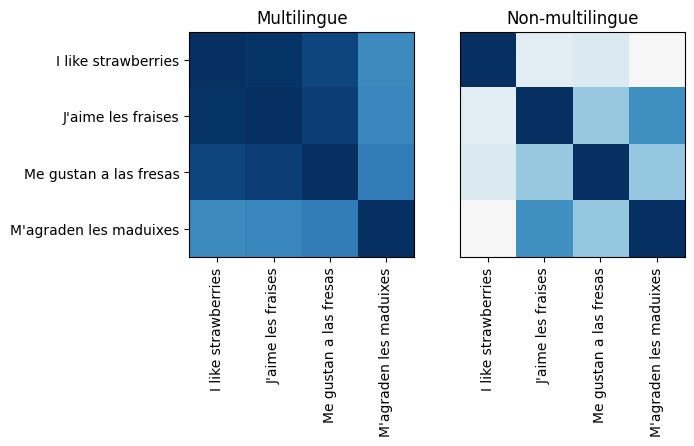

In [158]:
from sklearn.metrics.pairwise import cosine_distances

sentences = [
    "I like strawberries",
    "J'aime les fraises",
    "Me gustan a las fresas",
    "M'agraden les maduixes"
]

# Multilingue
emb = sentence_model.encode(sentences)
multilingual_similarity = cosine_similarity(emb)
print("Modèle multilingue")
print(multilingual_similarity)

# Non multilingue
model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(sentences)
normal_similarity = cosine_similarity(emb)
print("Modèle non-multilingue")
print(normal_similarity)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.set_title("Multilingue")
ax.imshow(multilingual_similarity, cmap="RdBu", vmin=-1, vmax=+1)
ax.set_xticks([0, 1, 2, 3], sentences, rotation=90)
ax.set_yticks([0, 1, 2, 3], sentences)

ax = fig.add_subplot(122)
ax.set_title("Non-multilingue")
ax.imshow(normal_similarity, cmap="RdBu", vmin=-1, vmax=+1)
ax.set_xticks([0, 1, 2, 3], sentences, rotation=90)
ax.set_yticks([], [])
plt.show()

## 2. Réduction de dimensionalité

In [14]:
# algorithme de réduction de dimensionalité
from umap import UMAP
umap = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    low_memory=True,
    random_state=42
)

## 3. Clustering

In [24]:
# algorithme de clustering
from hdbscan import HDBSCAN
hdbscan = HDBSCAN(
    min_cluster_size=250,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True,
)

## 4. Exécution de la pipeline